# Iceberg Image Detection

To avoid another disaster similar to Titanic, we want to create a model that is able to predict from satellite images if an object is an iceberg or a ship.

We use a dataset of satellite images, our goal is to understand it and create a model using this dataset to be able to predict from a given satellite image if it corresponds to a ship or an iceberg. Using these predictions we would know the areas to avoid when traveling by sea.


## 1) Data acquisition
We load the data from its location and explore it :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the data
df_train = pd.read_json('data/iceberg/train.json')

In [2]:
# Checking some train data examples
df_train.head() 

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


## 2) Data preparation
We load the data from its location and explore it :
### 2.1) Variables Signification
<ul>
<li>id - the id of the image</li>
<li>band_1, band_2 - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements. Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). More background on the satellite imagery can be found here.</li>
<li>inc_angle - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage.</li>
<li>is_iceberg - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.</li>
</ul>

### 2.2) Missing data
Let us check for the presence of <b>na</b> values in the <i>inc_angle</i> variable

In [4]:
len(df_train[df_train['inc_angle']=='na'])

133

In [5]:
# We replace the 'na' string values with nan values so it can be easily handled
df_train['inc_angle'].replace('na',np.nan, inplace = True)

In [6]:
# Now the df info shows that there are null values in inc_angle which was not visible before
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1604 non-null   object 
 1   band_1      1604 non-null   object 
 2   band_2      1604 non-null   object 
 3   inc_angle   1471 non-null   float64
 4   is_iceberg  1604 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 62.8+ KB


In [8]:
df_train['inc_angle'] = df_train['inc_angle'].replace('na',np.nan)

# Let's drop the NaN values.
trainData_noNaN = df_train.dropna()

# From the noNaN dataset, let's get the mean and standard deviation.
incAngleTrain_noNaN = np.array(trainData_noNaN['inc_angle'], dtype=float)
incAngleMean = incAngleTrain_noNaN.mean(dtype=np.float64)
incAngleStd = incAngleTrain_noNaN.std(dtype=np.float64)

# Using the mean and standard deviation, normalize the inclination angle to zero mean and standard deviation of 1.
df_train['inc_angle'] -= incAngleMean
df_train['inc_angle'] /= incAngleStd

# Replace the NaN values with the mean value, 0.0
df_train['inc_angle'] = df_train['inc_angle'].replace(np.nan, 0.0)

incAngleTrain = df_train['inc_angle']

### 2.3) Exploratory Data analysis
Do we really need two variables (band 1 & 2)?
Let us check their distribution :

C:\Users\William\AppData\Local\Temp\ipykernel_9180\3841311639.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(totalBand1, label='Band 1')
C:\Users\William\AppData\Local\Temp\ipykernel_9180\3841311639.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(totalBand2, label='Band 2')


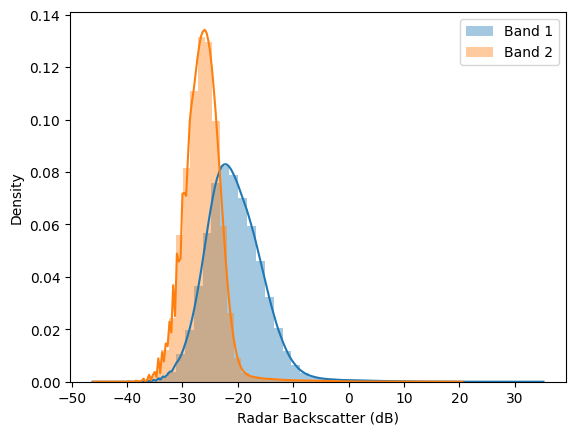

In [9]:
totalBand1 = []
totalBand2 = []
for imageVector in df_train['band_1']:
    for dB in imageVector:
        totalBand1.append(dB)
for imageVector in df_train['band_2']:
    for dB in imageVector:
        totalBand2.append(dB)
sns.distplot(totalBand1, label='Band 1')
sns.distplot(totalBand2, label='Band 2')
plt.legend()
plt.autoscale()
plt.xlabel('Radar Backscatter (dB)')
plt.ylabel('Density')
plt.savefig('Radar Backscatter Distribution.jpg')
plt.show()

### 2.4) Image visualisation :
Since the band 1 & 2 are images, let us plot them alongside their labels

Given the distribution visualised, should we keep both variables? Why?

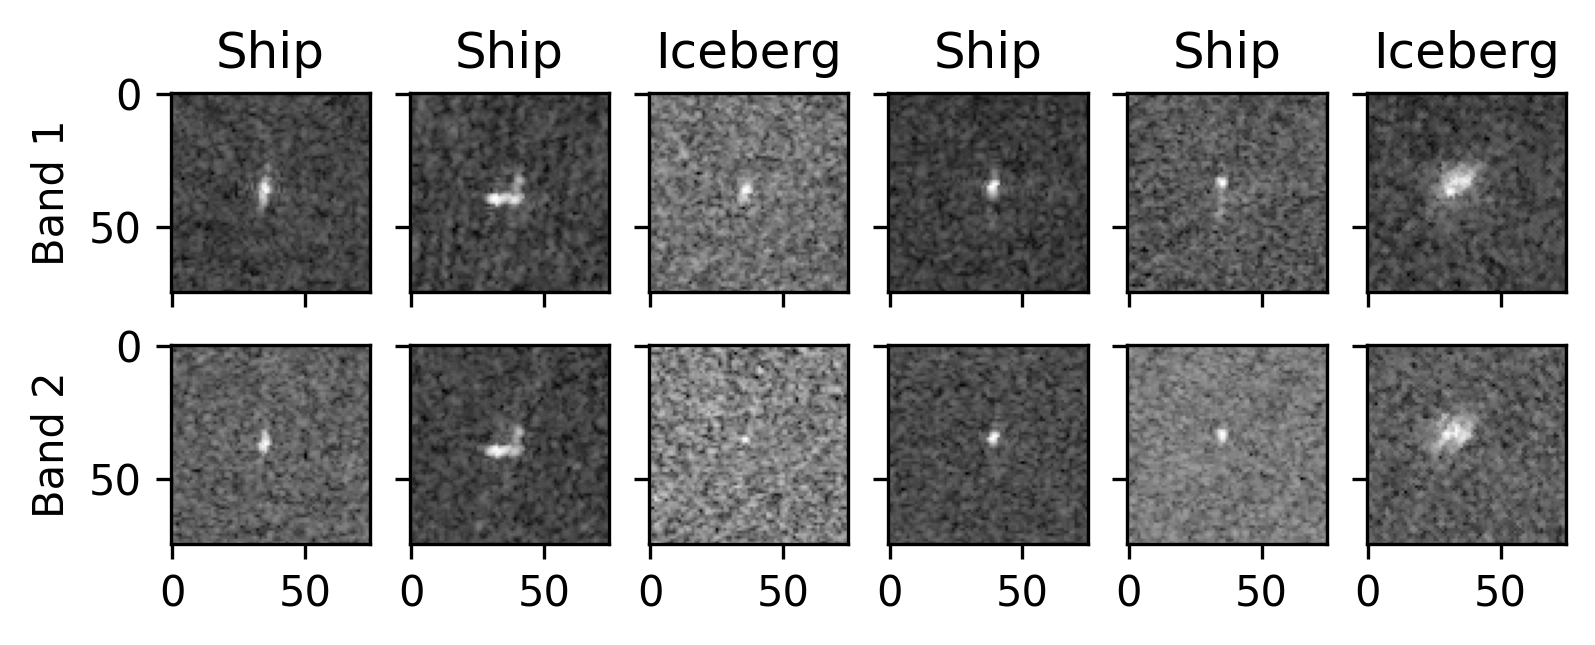

In [10]:
f, axarr = plt.subplots(nrows=2, ncols=6, sharex=True, sharey=True, figsize=(6,2), dpi=300)
for img in range (6):
    axarr[0, img].imshow(np.array(df_train['band_1'][img]).reshape((75,75)),cmap='binary_r')
    if df_train['is_iceberg'][img]==0:
        axarr[0, img].set_title('Ship')
    else:
        axarr[0, img].set_title('Iceberg')
    axarr[1, img].imshow(np.array(df_train['band_2'][img]).reshape((75,75)),cmap='binary_r')
axarr[0, 0].set_ylabel('Band 1')
axarr[1, 0].set_ylabel('Band 2')
plt.savefig('radar.jpg')
plt.show()

### 2.5) Data splitting and preparation :
We need to split our data into two sets : training and validation

We also need to reshape and normalize the images 

In [11]:
from sklearn.model_selection import train_test_split
df_train_model = df_train.drop(columns=['id'])
# TO-DO :
#   - Separate the target from the features
#   - Split the data into train and validation
Y_train = df_train_model.is_iceberg
X_train = df_train_model.loc[:,df_train_model.columns!='is_iceberg']

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state=1, train_size=0.8)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(1283, 3) (1283,)
(321, 3) (321,)


In [12]:
# Function used to reshape and normalize
def reshape_normalize(band):
    radarImage = np.empty([1,75,75,1])
    for vector in band:
        bandMatrix = np.array(vector).reshape((75, 75))
        bandMatrix = (bandMatrix - bandMatrix.min()) / (bandMatrix.max() - bandMatrix.min())
        bandMatrix = np.expand_dims(bandMatrix, axis=0)
        bandMatrix = np.expand_dims(bandMatrix, axis=-1)
        radarImage = np.concatenate((radarImage, bandMatrix))
    radarImage = np.delete(radarImage, 0, 0)
    return radarImage

In [13]:
band_1_train = reshape_normalize(X_train['band_1'])
band_2_train = reshape_normalize(X_train['band_2'])
angle_train = X_train['inc_angle']

## 3) Model creation :
Now that our data is ready, we need to create our model.

Unlike the sequential models that we have seen before, this time we will create a non-sequential model. This model has three separate branches that are later merged :

<ol>
<li>Convolutional Model for the first band</li>
<li>Convolutional Model for the second band</li>
<li>Input layer for the inc_angle</li>
</ol>

These three 'models' are then merged and fed to a Fully Connected Neural Network (Dense)

In [14]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras import optimizers
from keras import regularizers

band1 = Input(shape=(75,75,1))
band2 = Input(shape=(75,75,1))
angle = Input(shape=(1))

# TO-DO : 
#   - Complete the two convolution models
#   - Combine the results of the convolution models with inc_angle variable and feed them to an mlp 

# Define the model architecture
# Start with Convolutional Model 1 for Band 1 Data
conv1 = Conv2D(filters= 64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(75, 75, 1))(band1)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(filters= 32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(75, 75, 1))(conv1)

conv1 = GlobalAveragePooling2D()(conv1)

# Start with Convolutional Model 2 for Band 2 Data
conv2 = Conv2D(filters= 64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(75, 75, 1))(band2)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(filters= 32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(75, 75, 1))(conv2)

conv2 = GlobalAveragePooling2D()(conv2)

# Combine the convolution models' outputs as well as the inc_angle
merge = keras.layers.concatenate([conv1, conv2, angle])

# Let's use a final multi-layer perceptron to weigh the three inputs
mlp = Dense(500, activation='relu')(merge)
mlp = Dense(250, activation='relu')(mlp)
mlp = Dense(100, activation='relu')(mlp)
output = Dense(1, activation='sigmoid')(mlp)

model = Model(inputs = [band1, band2, angle], outputs = output)

#Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 64)   1664        ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 75, 75, 64)   1664        ['input_2[0][0]']                
                                                                                              

In [15]:
# TO-DO : Train the model
model.fit(x=[band_1_train, band_2_train, angle_train ], y = Y_train, epochs = 15, verbose = 1)

Epoch 1/15
41/41 [==============================] - 52s 1s/step - loss: 0.6921 - accuracy: 0.5175
Epoch 2/15
41/41 [==============================] - 57s 1s/step - loss: 0.6725 - accuracy: 0.6111
Epoch 3/15
41/41 [==============================] - 57s 1s/step - loss: 0.6468 - accuracy: 0.6298
Epoch 4/15
41/41 [==============================] - 52s 1s/step - loss: 0.6011 - accuracy: 0.6890
Epoch 5/15
41/41 [==============================] - 58s 1s/step - loss: 0.5976 - accuracy: 0.6773
Epoch 6/15
41/41 [==============================] - 57s 1s/step - loss: 0.5526 - accuracy: 0.7124
Epoch 7/15
41/41 [==============================] - 54s 1s/step - loss: 0.5523 - accuracy: 0.7319
Epoch 8/15
41/41 [==============================] - 59s 1s/step - loss: 0.5642 - accuracy: 0.7311
Epoch 9/15
41/41 [==============================] - 59s 1s/step - loss: 0.5599 - accuracy: 0.7171
Epoch 10/15
41/41 [==============================] - 57s 1s/step - loss: 0.5504 - accuracy: 0.7233
Epoch 11/15
41/41 [

In [16]:
# Prepare the data for the validation set
band_1_test = reshape_normalize(X_valid['band_1'])
band_2_test = reshape_normalize(X_valid['band_2'])
angle_test = X_valid['inc_angle']

In [17]:
# Evaluate your model
# TO-DO : Specify the parameters for this function
score = model.evaluate(x=[band_1_test,band_2_test,angle_test],y=Y_valid)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

11/11 [==============================] - 2s 138ms/step - loss: 0.5734 - accuracy: 0.7290
Test loss: 0.5734071731567383
Test accuracy: 0.7289719581604004
